In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import keras
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
train=pd.read_csv( '/content/drive/MyDrive/kaggle-nabil-badri/olid-training-v1.0.tsv',sep="\t")
test=pd.read_csv('/content/drive/MyDrive/kaggle-nabil-badri/testset-levela.tsv',sep="\t")
y_test=pd.read_csv( '/content/drive/MyDrive/kaggle-nabil-badri/labels-levela.csv',header=None).iloc[:,-1]
#OFF=0 
#NOT=1

In [ ]:
y_train=train['subtask_a']
train=train['tweet']
test=test['tweet']
y_train=pd.factorize(y_train)[0]
y_test=pd.factorize(y_test)[0]

import collections
collections.Counter(y_train)

#Counter({0: 4400, 1: 8840})

Counter({0: 4400, 1: 8840})

In [ ]:
x=train[323].lower().replace('@user','').replace('url','')
x=re.sub('[^A-Za-z]', ' ', x)
re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',x)

'   you are grossly misinterpreting who is against this  people across all parties condemn this action  look no further than bill davis and brian mulroney to see that even conservatives think this is a horrible decision '

In [ ]:
# Creating the training corpus
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
corpus_train = []
for i in train:
    x=i.lower()
    x=x.replace('@user','')
    x=x.replace('@[\w\-]+','')
    #x=x.translate(str.maketrans('', '', string.punctuation))
    x = re.sub('[^A-Za-z]', ' ', x)
    #x=re.sub('\s+',' ',x)
    x=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',x) #url
    #x = [lemmatizer.lemmatize(token) for token in x.split(" ")]
    #x = [word for word in x if not word in stop_words]
    #x=" ".join(x)
    corpus_train.append(x)    
# Creating the training corpus
corpus_test = []
for i in test:
    x=i.lower()
    x=x.replace('@user','')
    x=x.replace('@[\w\-]+','')
    #x=x.translate(str.maketrans('', '', string.punctuation))
    x = re.sub('[^A-Za-z]', ' ', x)
    #x=re.sub('\s+',' ',x)
    x=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',x) #url
    #x = [lemmatizer.lemmatize(token) for token in x.split(" ")]
    #x = [word for word in x if not word in stop_words]
    #x=" ".join(x)
    corpus_test.append(x) 

In [ ]:
corpus_train[0]

' she should ask a few native americans what their take on this is '

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
max_words = 5000 #frequency of words to be kept
max_len = 200

tokenize = Tokenizer(num_words=max_words)
tokenize.fit_on_texts(corpus_train)
sequences = tokenize.texts_to_sequences(corpus_train)
word_index = tokenize.word_index
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
num_words = min(max_words, len(word_index)) + 1
print(num_words)

5001


In [ ]:
!unzip /content/drive/MyDrive/kaggle-nabil-badri/wikinews300d1mvec.zip

Archive:  /content/drive/MyDrive/kaggle-nabil-badri/wikinews300d1mvec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
embedding_path1 = "/content/wiki-news-300d-1M.vec"
embedding_path2 = "/content/drive/MyDrive/kaggle-nabil-badri/glove.840B.300d.txt"
embed_size = 300

In [ ]:
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def build_matrix(embedding_path, word_index):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

    nb_words = min(max_words, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    for word, i in word_index.items():
        if i >= max_words:
            continue
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


In [ ]:
fasttext=build_matrix(embedding_path1, word_index)
glove_emb=build_matrix(embedding_path2, word_index)

In [ ]:
fasttext.shape

(5001, 300)

ccombinaison des deux embedding


In [ ]:
embedding_matrix=np.mean((fasttext,glove_emb),axis=0)
embedding_matrix.shape

(5001, 300)

In [ ]:
test_sequences = tokenize.texts_to_sequences(corpus_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
from keras import backend as K
def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
callbacks = keras.callbacks.EarlyStopping(monitor='val_f1', mode='max', verbose=1,
                                          patience=8,restore_best_weights = True)

In [ ]:
from keras.models import Sequential,Model
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from keras.layers import Embedding,Dense,GRU
from keras.layers import Dropout,Bidirectional,GlobalMaxPool1D,GlobalAveragePooling1D
from keras.layers import SpatialDropout1D,concatenate,Input
from keras.optimizers import RMSprop
from keras.initializers import Constant
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights=dict(enumerate(class_weights))

# BIGRUs Model

### Training a model with GloVe and Fasttext embedding

In [ ]:
inp=Input(max_len)
#Embedding Layer 
x=Embedding(num_words,embed_size,embeddings_initializer=Constant(embedding_matrix),
            input_length=max_len,trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
#GRU Bidrirectionnel
x=Bidirectional(GRU(150, return_sequences = True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPool1D()(x)
conc = concatenate([avg_pool, max_pool])

 
x=Dropout(0.1)(conc)
out=Dense(64, activation="relu")(x)
out=Dense(32, activation="relu")(x)

out=Dense(1, activation="sigmoid")(x)

model=Model(inp,out)

mcp_save = ModelCheckpoint('/content/sample_data/model.mdl_wts.hdf5', save_best_only=True,
                           monitor='val_loss', mode='min',patience = 5)



In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 300)     1500300     input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 200, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200, 300)     406800      spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

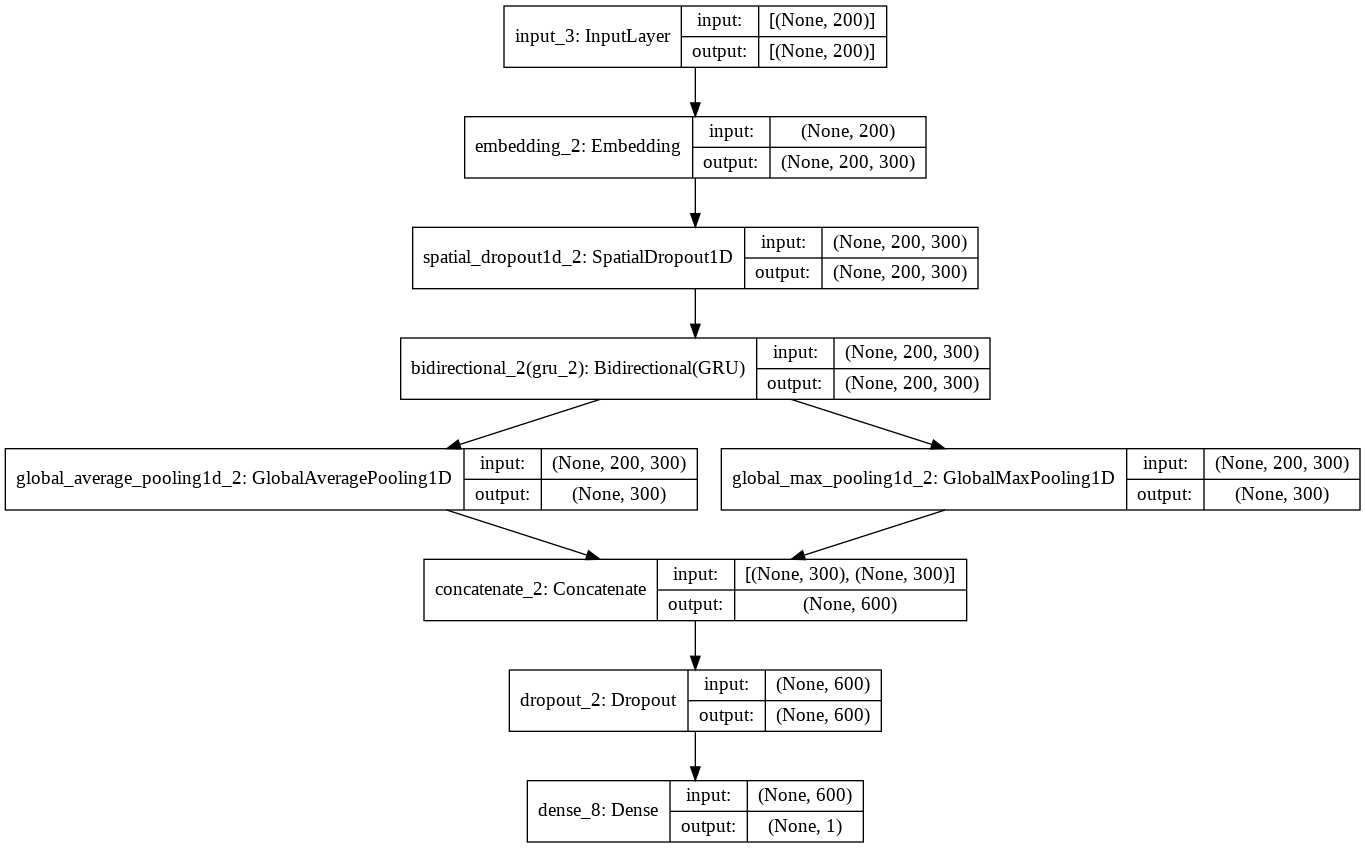

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=30,verbose=1,class_weight=class_weights,
          validation_data=(test_sequences_matrix,y_test),callbacks=[callbacks])

Epoch 1/30
104/104 [==============================] - 9s 56ms/step - loss: 0.6256 - f1: 0.6314 - val_loss: 0.4219 - val_f1: 0.8776
Epoch 2/30
104/104 [==============================] - 5s 50ms/step - loss: 0.5114 - f1: 0.8128 - val_loss: 0.4083 - val_f1: 0.8760
Epoch 3/30
104/104 [==============================] - 5s 51ms/step - loss: 0.5007 - f1: 0.8205 - val_loss: 0.3879 - val_f1: 0.8829
Epoch 4/30
104/104 [==============================] - 5s 51ms/step - loss: 0.4823 - f1: 0.8331 - val_loss: 0.4154 - val_f1: 0.8718
Epoch 5/30
104/104 [==============================] - 5s 51ms/step - loss: 0.4739 - f1: 0.8277 - val_loss: 0.4016 - val_f1: 0.8798
Epoch 6/30
104/104 [==============================] - 5s 51ms/step - loss: 0.4574 - f1: 0.8367 - val_loss: 0.4205 - val_f1: 0.8632
Epoch 7/30
104/104 [==============================] - 5s 51ms/step - loss: 0.4452 - f1: 0.8389 - val_loss: 0.3844 - val_f1: 0.8853
Epoch 8/30
104/104 [==============================] - 5s 51ms/step - loss: 0.4326 -

In [ ]:
print(model.evaluate(test_sequences_matrix,y_test))

27/27 [==============================] - 0s 17ms/step - loss: 0.3814 - f1: 0.8936
[0.38141271471977234, 0.8935668468475342]


In [ ]:
y_pred = model.predict(test_sequences_matrix, batch_size=128, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred = (y_pred > 0.5)

print(classification_report(y_test, y_pred))


7/7 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

           0       0.77      0.63      0.69       240
           1       0.87      0.93      0.90       620

    accuracy                           0.84       860
   macro avg       0.82      0.78      0.79       860
weighted avg       0.84      0.84      0.84       860



In [ ]:
f1_score(y_test, y_pred, average="weighted")

0.8392678491465877

In [ ]:
from tensorflow import keras
keras.backend.clear_session()

In [ ]:
metric =metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred, average='macro'), metrics.recall_score(y_test, y_pred), metrics.precision_score(y_test, y_pred)

(0.0, 1.0)

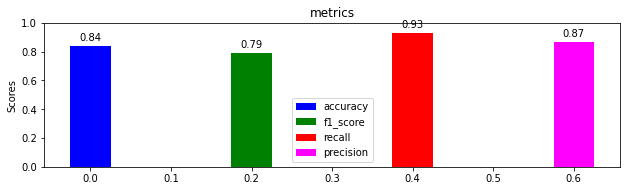

In [ ]:
fig = plt.figure()
fig.set_size_inches(8,2)
ax = fig.add_axes([0,0,1,1])
rect1 = ax.bar(0.00,round(metric[0], 2), color = 'b', width = 0.05)
rect2 = ax.bar(0.20, round(metric[1], 2), color = 'g', width = 0.05)
rect3 = ax.bar(0.40, round(metric[2], 2) , color = 'r', width = 0.05)
rect4 = ax.bar(0.60, round(metric[3], 2) , color = (1, 0, 1), width = 0.05)

ax.set_ylabel('Scores')
ax.set_title('metrics')
def autolabel(rects):
  """Attach a text label above each bar in *rects*, displaying its height."""
  for rect in rects:
      height = rect.get_height()
      ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
autolabel(rect4)
ax.legend(labels=['accuracy', 'f1_score', 'recall', 'precision'],loc='best')
plt.ylim(0, 1)

### Training on Fasttext Embedding Only

In [ ]:
keras.backend.clear_session()

In [ ]:
inp=Input(shape=(max_len, ))
x=Embedding(num_words,embed_size,embeddings_initializer=Constant(fasttext),#Set Fasttext Embedding
            input_length=max_len,trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x=Bidirectional(GRU(150, return_sequences = True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPool1D()(x)
conc = concatenate([avg_pool, max_pool])


x=Dropout(0.1)(conc)
out=Dense(64, activation="relu")(x)
out=Dense(32, activation="relu")(x)

out=Dense(1, activation="sigmoid")(x)

model_ft=Model(inp,out)

mcp_save = ModelCheckpoint('/content/sample_data/model.mdl_wts.hdf5', save_best_only=True,
                           monitor='val_loss', mode='min',patience = 5)


In [ ]:
model_ft.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])

In [ ]:
model_ft.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     1500300     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 200, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 300)     406800      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
model_ft.fit(sequences_matrix,y_train,batch_size=128,epochs=20,verbose=1,class_weight=class_weights,
          validation_data=(test_sequences_matrix,y_test),callbacks=[callbacks])

Epoch 1/20
104/104 [==============================] - 8s 57ms/step - loss: 0.6400 - f1: 0.5908 - val_loss: 0.4783 - val_f1: 0.8600
Epoch 2/20
104/104 [==============================] - 5s 51ms/step - loss: 0.5156 - f1: 0.8137 - val_loss: 0.4096 - val_f1: 0.8786
Epoch 3/20
104/104 [==============================] - 5s 51ms/step - loss: 0.4943 - f1: 0.8272 - val_loss: 0.4369 - val_f1: 0.8615
Epoch 4/20
104/104 [==============================] - 5s 51ms/step - loss: 0.4856 - f1: 0.8280 - val_loss: 0.4282 - val_f1: 0.8629
Epoch 5/20
104/104 [==============================] - 5s 52ms/step - loss: 0.4740 - f1: 0.8350 - val_loss: 0.4073 - val_f1: 0.8766
Epoch 6/20
104/104 [==============================] - 6s 55ms/step - loss: 0.4640 - f1: 0.8372 - val_loss: 0.4047 - val_f1: 0.8824
Epoch 7/20
104/104 [==============================] - 5s 51ms/step - loss: 0.4510 - f1: 0.8437 - val_loss: 0.3988 - val_f1: 0.8840
Epoch 8/20
104/104 [==============================] - 5s 51ms/step - loss: 0.4362 -

In [ ]:
print(model_ft.evaluate(test_sequences_matrix,y_test))

27/27 [==============================] - 0s 10ms/step - loss: 0.4418 - f1: 0.8847
[0.4417601227760315, 0.8846835494041443]


In [ ]:
y_pred_ft = model_ft.predict(test_sequences_matrix, batch_size=128, verbose=1)
y_pred_bool_ft = np.argmax(y_pred, axis=1)
y_pred_ft = (y_pred_ft > 0.5)

print(classification_report(y_test, y_pred_ft))


7/7 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.74      0.61      0.67       240
           1       0.86      0.92      0.89       620

    accuracy                           0.83       860
   macro avg       0.80      0.76      0.78       860
weighted avg       0.83      0.83      0.83       860



In [ ]:
metric_ft =metrics.accuracy_score(y_test, y_pred_ft), metrics.f1_score(y_test, y_pred_ft, average='macro'), metrics.recall_score(y_test, y_pred_ft), metrics.precision_score(y_test, y_pred_ft)

(0.0, 1.0)

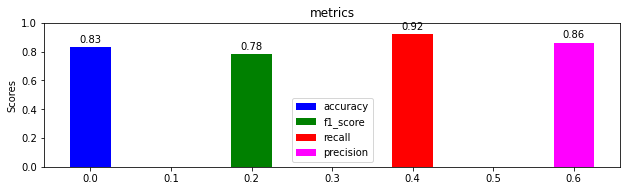

In [ ]:
fig = plt.figure()
fig.set_size_inches(8,2)
ax = fig.add_axes([0,0,1,1])
rect1 = ax.bar(0.00,round(metric_ft[0], 2), color = 'b', width = 0.05)
rect2 = ax.bar(0.20, round(metric_ft[1], 2), color = 'g', width = 0.05)
rect3 = ax.bar(0.40, round(metric_ft[2], 2) , color = 'r', width = 0.05)
rect4 = ax.bar(0.60, round(metric_ft[3], 2) , color = (1, 0, 1), width = 0.05)

ax.set_ylabel('Scores')
ax.set_title('metrics')


autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
autolabel(rect4)
ax.legend(labels=['accuracy', 'f1_score', 'recall', 'precision'],loc='best')
plt.ylim(0, 1)

### Training on Glove Embedding

In [ ]:
keras.backend.clear_session()

In [ ]:
inp=Input(shape=(max_len, ))
x=Embedding(num_words,embed_size,embeddings_initializer=Constant(glove_emb),#Set GloVe Embedding
            input_length=max_len,trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x=Bidirectional(GRU(150, return_sequences = True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPool1D()(x)
conc = concatenate([avg_pool, max_pool])


x=Dropout(0.1)(conc)
out=Dense(64, activation="relu")(x)
out=Dense(32, activation="relu")(x)

out=Dense(1, activation="sigmoid")(x)

model_gl=Model(inp,out)

mcp_save = ModelCheckpoint('/content/sample_data/model.mdl_wts.hdf5', save_best_only=True,
                           monitor='val_loss', mode='min',patience = 5)


In [ ]:
model_gl.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])

In [ ]:
model_gl.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     1500300     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 200, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 300)     406800      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
model_gl.fit(sequences_matrix,y_train,batch_size=128,epochs=20,verbose=1,class_weight=class_weights,
          validation_data=(test_sequences_matrix,y_test),callbacks=[callbacks])

Epoch 1/20
104/104 [==============================] - 8s 57ms/step - loss: 0.6105 - f1: 0.6536 - val_loss: 0.4504 - val_f1: 0.8593
Epoch 2/20
104/104 [==============================] - 5s 51ms/step - loss: 0.5026 - f1: 0.8190 - val_loss: 0.4787 - val_f1: 0.8357
Epoch 3/20
104/104 [==============================] - 5s 51ms/step - loss: 0.4786 - f1: 0.8267 - val_loss: 0.4172 - val_f1: 0.8715
Epoch 4/20
104/104 [==============================] - 5s 51ms/step - loss: 0.4663 - f1: 0.8356 - val_loss: 0.3813 - val_f1: 0.8892
Epoch 5/20
104/104 [==============================] - 5s 51ms/step - loss: 0.4429 - f1: 0.8503 - val_loss: 0.4293 - val_f1: 0.8523
Epoch 6/20
104/104 [==============================] - 5s 51ms/step - loss: 0.4359 - f1: 0.8440 - val_loss: 0.3894 - val_f1: 0.8773
Epoch 7/20
104/104 [==============================] - 5s 51ms/step - loss: 0.4200 - f1: 0.8562 - val_loss: 0.4019 - val_f1: 0.8690
Epoch 8/20
104/104 [==============================] - 5s 51ms/step - loss: 0.4077 -

In [ ]:
print(model_gl.evaluate(test_sequences_matrix,y_test))

27/27 [==============================] - 0s 11ms/step - loss: 0.4821 - f1: 0.8896
[0.48209846019744873, 0.8896205425262451]


In [ ]:
y_pred_gl = model_gl.predict(test_sequences_matrix, batch_size=128, verbose=1)
y_pred_bool_gl = np.argmax(y_pred, axis=1)
y_pred_gl = (y_pred_gl > 0.5)

print(classification_report(y_test, y_pred_gl))


7/7 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.76      0.61      0.68       240
           1       0.86      0.93      0.89       620

    accuracy                           0.84       860
   macro avg       0.81      0.77      0.78       860
weighted avg       0.83      0.84      0.83       860



In [ ]:
metric_gl =metrics.accuracy_score(y_test, y_pred_gl), metrics.f1_score(y_test, y_pred_gl, average='macro'), metrics.recall_score(y_test, y_pred_gl), metrics.precision_score(y_test, y_pred_gl)

(0.0, 1.0)

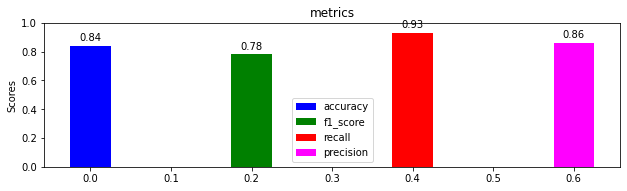

In [ ]:
fig = plt.figure()
fig.set_size_inches(8,2)
ax = fig.add_axes([0,0,1,1])
rect1 = ax.bar(0.00,round(metric_gl[0], 2), color = 'b', width = 0.05)
rect2 = ax.bar(0.20, round(metric_gl[1], 2), color = 'g', width = 0.05)
rect3 = ax.bar(0.40, round(metric_gl[2], 2) , color = 'r', width = 0.05)
rect4 = ax.bar(0.60, round(metric_gl[3], 2) , color = (1, 0, 1), width = 0.05)

ax.set_ylabel('Scores')
ax.set_title('metrics')

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
autolabel(rect4)
ax.legend(labels=['accuracy', 'f1_score', 'recall', 'precision'],loc='best')
plt.ylim(0, 1)

### Comparing the three results

In [ ]:
Data = [('Fasttext',) + metric_ft  ,
        ('GloVe',)+ metric_gl ,
         ('Fasttext + GloVe',)+ metric ]

In [ ]:
Results = pd.DataFrame(data =  Data , columns=['Embedding','Accuracy','F1_score','Recall','Precision'])

In [ ]:
Results

,Embedding,Accuracy,F1_score,Recall,Precision
0,Fasttext,0.832558,0.778788,0.919355,0.858434
1,GloVe,0.838372,0.784829,0.927419,0.859492
2,Fasttext + GloVe,0.844186,0.794770,0.925806,0.867069
